In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Carga de datos

Estaremos trabajando con un conjunto de datos de imágenes. Es un dataset conocido como MNIST, que contiene imágenes de números escritos a mano (del 0 al 9). Cada imagen es de 28x28 pixeles, lo que equivale a 784 pixeles en total por imagen. Los valores van de 0 a 255, donde 0 es negro y 255 es blanco.

En total, son poco más de 42,000 números escritos a mano.

In [2]:
data = pd.read_csv(r'C:\Users\abrah\Documents\Maestría\Segundo_semestre\Programacion_2\train.csv')
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preparación de datos

- Después de cargar el dataset, lo convertimos en un array de numpy y lo mezclamos de forma aleatoria.
- Usando el atributo shape le asignamos valores a m y n: m será el número de filas y n el de columnas de la matriz.

### División de los datos
Conjunto de desarrollo:
- Crea una muestra de 1,000 elementos. Luego se transpone la matriz para intercambiar filas por columnas.
- Y_dev tiene las etiquetas. En este caso, son los números del 0 al 9 de la base de datos.
- X_dev tiene las imágenes. Son los valores de los pixeles.

Conjunto de entrenamiento:
- Se toman el resto de imágenes para entrenamiento. En este caso es desde 1,000 hasta m.
- Y_train son las etiquetas de entrenamiento.
- X_train son los datos de las imágenes en entrenamiento.

Normalización:
Este paso es importante para que nuestros valores vayan de 0 a 1, donde 0 es negro y 1 la máxima intensidad. Los valores intermedios serán los tonos de grises.

Si los datos no están normalizados, la diferencia de magnitud puede hacer que el modelo sea mucho más lento. Por ejemplo, si un pixel tiene originalmente una intensidad de 200 su normalización sería:

$ \frac{200}{255} = 0.784 $

Si el pixel fuera más oscuro, por emeplo con valor de 50, su normalización sería:

$ \frac {50}{255} = 0.196 $ 

Así, el modelo recibe valores entre 0 y 1 en lugar de entre 0 y 255, lo que facilita los cálculos.

In [9]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_dev = data[0:1000].T
Y_dev = data_dev[0]
X_dev = data_dev[1:n] / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

# Inicialización de los parámetros

- La función inicializa los pesos ($W_1, W_2$) y los sesgos ($b_1, b_2$) para nuestra red neuronal de dos capas con valores aleatorios centrados en 0.
- np.random.rand() crea números aleatorios entre $0$ y $1$, luego le restamos $0.5$ para que los valores estén entre $-0.5$ y $0.5$. Esto es importante porque si todas las neuronas se inicializan en 0, aprenderían de la misma forma.

# Funciones de activación
- ReLU devuelve el valor original si es positivo, o $0$ si es negativo.
- Softmax convierte los valores en probabilidades (valores entre 0 y 1 que suman 1).
- La propagación hacia adelante calcula las salidas de cada capa:

$
Z_1 = W_1 \cdot X + b_1
$

$
A_1 = ReLU(Z_1)
$

$
Z_2 = W_2 \cdot A_1 + b_2
$

$
A_2 = softmax(Z_2)
$

In [10]:
def init_params(): # Aquí se inicializan los parámetros de la red
    W1 = np.random.rand(10, 784) - 0.5 # pesos de la primera capa (10 neuronas, 784 entradas)
    b1 = np.random.rand(10, 1) - 0.5 # sesgos de la primera capa (10 neuronas, 1 sesgo)
    W2 = np.random.rand(10, 10) - 0.5 # pesos de la segunda capa (10 neuronas, 10 entradas)
    b2 = np.random.rand(10, 1) - 0.5 # sesgos de la segunda capa (10 neuronas, 1 sesgo)
    return W1, b1, W2, b2

def ReLU(Z): # Esta es una función de activación para la capa oculta
    return np.maximum(Z, 0)

def softmax(Z): # Función de activación para la capa de salida
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X): # Propagación hacia adelante
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

def ReLU_deriv(Z): # Derivada de la función de activación ReLU
    return Z > 0

def one_hot(Y): # Convierte las etiquetas a one-hot, un formato de vector binario
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y): # Propagación hacia atrás para calcular los gradientes de la función de pérdida
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha): # Actualiza los parámetros de la red con el algoritmo de gradiente descendente
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

# Predicciones y evaluación

- get_predictions() devuelve la clase con mayor probabilidad.
- get_accuracy() calcula la precisión comparando las predicciones con las etiquetas reales
- gradient_descent() entrena la red durante 500 iteraciones

In [11]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [12]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
[8 6 6 ... 5 2 6] [3 3 0 ... 4 2 7]
0.09714634146341464
Iteration:  10
[3 0 6 ... 5 2 7] [3 3 0 ... 4 2 7]
0.15617073170731707
Iteration:  20
[3 0 6 ... 7 2 7] [3 3 0 ... 4 2 7]
0.21
Iteration:  30
[3 0 6 ... 7 2 7] [3 3 0 ... 4 2 7]
0.27470731707317075
Iteration:  40
[3 0 1 ... 7 2 7] [3 3 0 ... 4 2 7]
0.3480731707317073
Iteration:  50
[3 0 6 ... 7 7 7] [3 3 0 ... 4 2 7]
0.3974146341463415
Iteration:  60
[3 6 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.4343658536585366
Iteration:  70
[3 1 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.4651707317073171
Iteration:  80
[3 1 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.4948292682926829
Iteration:  90
[3 8 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.5221463414634147
Iteration:  100
[3 8 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.548439024390244
Iteration:  110
[3 8 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.575170731707317
Iteration:  120
[3 8 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.5999024390243902
Iteration:  130
[3 8 0 ... 7 2 7] [3 3 0 ... 4 2 7]
0.621609756097561
Iteration:  140
[3 8 0 ... 7 2 

# Prueba y visualización
- make_predictions realiza la predicción de la red a partir de una entrada y sus parámetros.
- test_predictions prueba la predicción del modelo. Toma una imagen, la pasa por la red, hace la predicción y luego la compara la etiqueta real. También visualiza la imagen correspondiente al índice.

In [13]:
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [3]
Label:  3


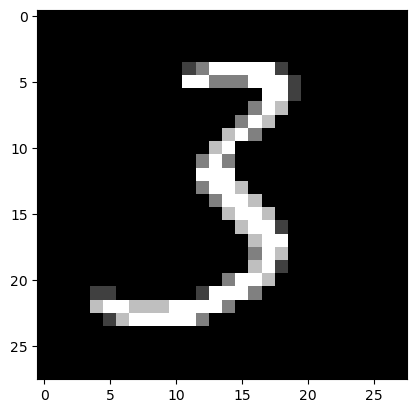

Prediction:  [8]
Label:  3


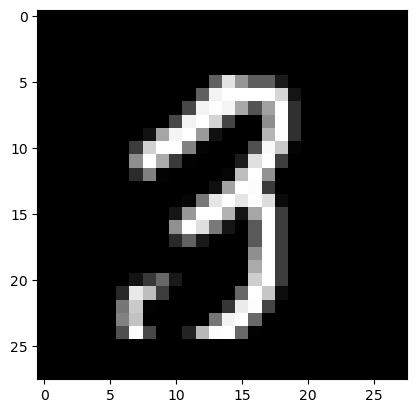

Prediction:  [0]
Label:  0


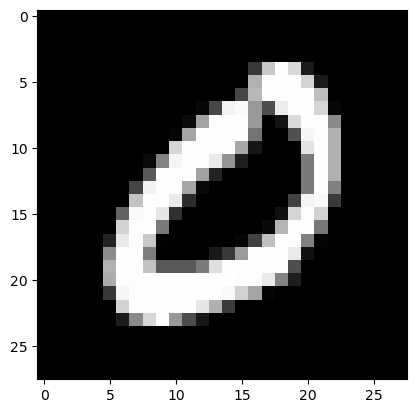

Prediction:  [2]
Label:  2


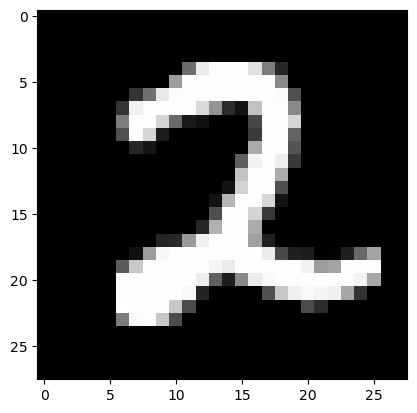

In [14]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [12]:
dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

[4 0 2 2 3 0 2 2 4 0 1 1 0 3 4 3 4 3 0 1 2 1 4 0 2 2 4 1 2 2 4 1 0 7 4 3 4
 1 0 0 0 0 1 8 0 0 1 0 0 2 0 7 3 1 7 2 2 0 4 2 4 4 4 3 0 3 0 4 0 0 1 0 0 0
 7 1 1 2 1 0 7 4 2 2 2 0 1 0 1 3 4 6 0 9 1 4 0 4 3 4 0 2 3 4 2 4 2 4 4 2 0
 1 7 4 3 2 7 2 0 3 1 1 8 1 0 1 2 2 8 7 0 2 4 0 0 1 1 0 1 0 0 0 4 7 0 0 1 2
 4 3 8 3 1 4 7 2 3 2 4 0 0 0 7 4 2 1 4 1 2 0 4 0 1 1 0 0 0 0 0 4 7 1 4 2 4
 2 7 7 1 1 0 0 2 4 0 0 1 4 3 0 2 1 2 3 3 1 1 0 2 1 4 0 0 4 0 4 7 0 1 0 2 2
 4 7 4 0 4 0 7 1 0 1 1 4 0 3 1 2 0 0 3 0 2 7 4 1 0 0 1 0 2 0 5 2 4 2 4 5 0
 4 4 1 0 0 3 0 5 0 2 0 3 7 2 1 0 2 1 0 3 7 1 4 2 0 0 0 9 1 2 4 1 3 2 2 1 3
 0 1 2 2 0 2 4 3 0 2 0 4 2 1 0 2 1 1 0 1 0 0 0 0 3 4 0 4 6 4 2 0 7 0 2 4 7
 2 4 3 3 3 0 0 0 0 0 8 1 0 0 4 2 2 4 4 1 4 0 0 2 2 4 3 1 0 4 0 1 0 1 0 1 3
 2 1 0 1 0 2 3 4 0 8 3 4 2 7 1 2 3 2 0 7 1 2 0 4 2 4 7 0 0 0 7 0 2 2 0 2 0
 2 1 2 0 4 1 2 0 4 0 0 0 2 4 4 1 0 6 1 2 0 7 0 4 1 1 2 4 2 4 2 4 1 4 2 4 1
 2 4 4 2 2 3 2 0 2 0 1 2 3 0 0 5 5 0 0 0 1 2 1 0 0 4 1 0 0 0 0 3 4 7 7 0 1
 2 0 1 0 1 0 7 1 7 4 3 7 

C:\Users\abrah\AppData\Local\Temp\ipykernel_20076\3962810796.py:12: RuntimeWarning: overflow encountered in exp
  A = np.exp(Z) / sum(np.exp(Z))
C:\Users\abrah\AppData\Local\Temp\ipykernel_20076\3962810796.py:12: RuntimeWarning: invalid value encountered in divide
  A = np.exp(Z) / sum(np.exp(Z))


np.float64(0.437)